# Training a Simple Patch Q-GAN on Images of digit 0.

## Imports

In [1]:
# Library imports
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pennylane as qml

# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Dataloading

In [2]:
class DigitsDataset(Dataset):
    def __init__(self, csv_file, label=0, transform=None):
        """
        Initialize the DigitsDataset class.

        Args:
        - csv_file (str): Path to the CSV file containing digit data.
        - label (int): The label to filter the dataset by (default is 0).
        - transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.csv_file = csv_file
        self.transform = transform
        self.df = self.filter_by_label(label)

    def filter_by_label(self, label):
        """
        Filter the dataset to include only data with a specific label.

        Args:
        - label (int): The label to filter the dataset by.

        Returns:
        - DataFrame: A pandas DataFrame containing only the data with the specified label.
        """
        # Use pandas to return a DataFrame of only zeros
        df = pd.read_csv(self.csv_file)
        df = df.loc[df.iloc[:, -1] == label]
        return df

    def __len__(self):
        """
        Return the length of the dataset.

        Returns:
        - int: The number of samples in the dataset.
        """
        return len(self.df)

    def __getitem__(self, idx):
        """
        Get a sample from the dataset by index.

        Args:
        - idx (int): The index of the sample to retrieve.

        Returns:
        - tuple: A tuple containing the image and its label.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Retrieve image data from DataFrame and normalize
        image = self.df.iloc[idx, :-1] / 16
        image = np.array(image)
        image = image.astype(np.float32).reshape(8, 8)

        if self.transform:
            # Apply transformation if specified
            image = self.transform(image)

        # Return image and label (always 0 since this class is currently designed to filter one label)
        return image, 0


### Plotting a batch of data

In [3]:
image_size = 8  # Height / width of the square images
batch_size = 1

transform = transforms.Compose([transforms.ToTensor()])
dataset = DigitsDataset(csv_file="/home/vansh/Downloads/optdigits.tra", transform=transform)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

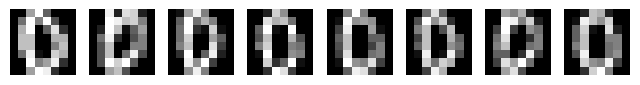

In [4]:
plt.figure(figsize=(8,2))

for i in range(8):
    image = dataset[i][0].reshape(image_size,image_size)
    plt.subplot(1,8,i+1)
    plt.axis('off')
    plt.imshow(image.numpy(), cmap='gray')

plt.show()

## Discriminator function for GAN

In [5]:
class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(image_size * image_size, 64),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            nn.Linear(64, 16),
            nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

In [6]:
# Quantum variables
n_qubits = 5  # Total number of qubits / N
n_a_qubits = 1  # Number of ancillary qubits / N_A
q_depth = 6  # Depth of the parameterised quantum circuit / D
n_generators = 4  # Number of subgenerators for the patch method / N_G

In [7]:
# Quantum simulator
dev = qml.device("lightning.qubit", wires=n_qubits)
# Enable CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

-------
-------

In [8]:
@qml.qnode(dev, diff_method="parameter-shift")
def quantum_circuit(noise, weights):
    """
    Define a quantum circuit using PennyLane.

    Args:
    - noise (array): Array containing the noise values for initializing the qubits.
    - weights (array): Array containing the weights for the parameterized layers.

    Returns:
    - array: Probabilities of measurement outcomes for the quantum circuit.
    """
    weights = weights.reshape(q_depth, n_qubits)

    # Initialise latent vectors
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

    return qml.probs(wires=list(range(n_qubits)))


# For further info on how the non-linear transform is implemented in Pennylane
# https://discuss.pennylane.ai/t/ancillary-subsystem-measurement-then-trace-out/1532
def partial_measure(noise, weights):
    """
    Perform a partial measurement on the quantum circuit and apply post-processing.

    Args:
    - noise (array): Array containing the noise values for initializing the qubits.
    - weights (array): Array containing the weights for the parameterized layers.

    Returns:
    - array: Probabilities of measurement outcomes after post-processing.
    """
    # Non-linear Transform
    probs = quantum_circuit(noise, weights)
    probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]
    probsgiven0 /= torch.sum(probs)

    # Post-Processing
    probsgiven = probsgiven0 / torch.max(probsgiven0)
    return probsgiven


In [9]:
class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self, n_generators, q_delta=1):
        """
        Initialize the PatchQuantumGenerator class.

        Args:
        - n_generators (int): Number of sub-generators to be used in the patch method.
        - q_delta (float, optional): Spread of the random distribution for parameter initialization.
        """
        super().__init__()

        # Initialize quantum parameters for each sub-generator
        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand(q_depth * n_qubits), requires_grad=True)
                for _ in range(n_generators)
            ]
        )
        self.n_generators = n_generators

    def forward(self, x):
        """
        Forward pass method of the PatchQuantumGenerator class.

        Args:
        - x (Tensor): Input tensor containing image data.

        Returns:
        - Tensor: Output tensor containing generated images.
        """
        # Size of each sub-generator output
        patch_size = 2 ** (n_qubits - n_a_qubits)

        # Create a Tensor to 'catch' a batch of images from the for loop. x.size(0) is the batch size.
        images = torch.Tensor(x.size(0), 0).to(device)

        # Iterate over all sub-generators
        for params in self.q_params:

            # Create a Tensor to 'catch' a batch of the patches from a single sub-generator
            patches = torch.Tensor(0, patch_size).to(device)
            for elem in x:
                # Obtain the output of the sub-generator for each image patch
                q_out = partial_measure(elem, params).float().unsqueeze(0)
                patches = torch.cat((patches, q_out))

            # Each batch of patches is concatenated with each other to create a batch of images
            images = torch.cat((images, patches), 1)

        return images


In [10]:
lrG = 0.3  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator
num_iter = 1000  # Number of training iterations

In [11]:
discriminator = Discriminator().to(device)  # Instantiate the discriminator and move it to the device (GPU if available)
generator = PatchQuantumGenerator(n_generators).to(device)  # Instantiate the quantum generator and move it to the device

# Binary cross entropy loss function
criterion = nn.BCELoss()

# Optimizers for discriminator and generator
optD = optim.SGD(discriminator.parameters(), lr=lrD)  # Optimizer for discriminator
optG = optim.SGD(generator.parameters(), lr=lrG)  # Optimizer for generator

# Labels for real and fake data
real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)  # Label for real data (1)
fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)  # Label for fake data (0)

# Fixed noise for visualization throughout training
fixed_noise = torch.rand(8, n_qubits, device=device) * math.pi / 2  # Generate fixed noise in range [0, pi/2)

# Iteration counter
counter = 0

# Collect images for plotting later
results = []
#List for saving Discriminator Error.
error_disc = []
#List for saving Generator Error.
error_gen = []
# Training loop
while True:
    for i, (data, _) in enumerate(dataloader):  # Iterate over batches of data from the data loader

        # Reshape data for training the discriminator
        data = data.reshape(-1, image_size * image_size)
        real_data = data.to(device)  # Move real data to the device (GPU if available)

        # Generate noise following a uniform distribution in range [0, pi/2)
        noise = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2
        fake_data = generator(noise)  # Generate fake data using the quantum generator

        # Training the discriminator
        discriminator.zero_grad()  # Reset gradients of the discriminator
        outD_real = discriminator(real_data).view(-1)  # Forward pass for real data
        outD_fake = discriminator(fake_data.detach()).view(-1)  # Forward pass for fake data (detached from generator)
        
        # Compute discriminator loss
        errD_real = criterion(outD_real, real_labels)  # Calculate loss for real data
        errD_fake = criterion(outD_fake, fake_labels)  # Calculate loss for fake data
        errD = errD_real + errD_fake  # Total discriminator loss
        # Backpropagate and update discriminator parameters
        errD.backward()  # Backpropagate gradients
        optD.step()  # Update discriminator parameters

        # Training the generator
        generator.zero_grad()  # Reset gradients of the generator
        outD_fake = discriminator(fake_data).view(-1)  # Forward pass for fake data through updated discriminator
        errG = criterion(outD_fake, real_labels)  # Calculate generator loss
        errG.backward()  # Backpropagate gradients
        optG.step()  # Update generator parameters

        counter += 1  # Increment iteration counter
        error_disc.append(errD)
        error_gen.append(errG)
        # Display loss values
        if counter % 10 == 0:
            print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')

            # Generate images for visualization
            test_images = generator(fixed_noise).view(8, 1, image_size, image_size).cpu().detach()

            # Save images every 50 iterations
            if counter % 50 == 0:
                results.append(test_images)  # Append generated images to results list

        # Check if maximum number of iterations reached
        if counter == num_iter:
            break
    if counter == num_iter:
        break


Iteration: 10, Discriminator Loss: 1.361, Generator Loss: 0.596
Iteration: 20, Discriminator Loss: 1.351, Generator Loss: 0.604
Iteration: 30, Discriminator Loss: 1.308, Generator Loss: 0.624
Iteration: 40, Discriminator Loss: 1.302, Generator Loss: 0.628
Iteration: 50, Discriminator Loss: 1.270, Generator Loss: 0.655
Iteration: 60, Discriminator Loss: 1.309, Generator Loss: 0.607
Iteration: 70, Discriminator Loss: 1.252, Generator Loss: 0.652
Iteration: 80, Discriminator Loss: 1.302, Generator Loss: 0.594
Iteration: 90, Discriminator Loss: 1.254, Generator Loss: 0.615
Iteration: 100, Discriminator Loss: 1.290, Generator Loss: 0.593
Iteration: 110, Discriminator Loss: 1.198, Generator Loss: 0.659
Iteration: 120, Discriminator Loss: 1.294, Generator Loss: 0.594
Iteration: 130, Discriminator Loss: 1.262, Generator Loss: 0.624
Iteration: 140, Discriminator Loss: 1.260, Generator Loss: 0.600
Iteration: 150, Discriminator Loss: 1.259, Generator Loss: 0.615
Iteration: 160, Discriminator Loss

## Plotting the Generatred images

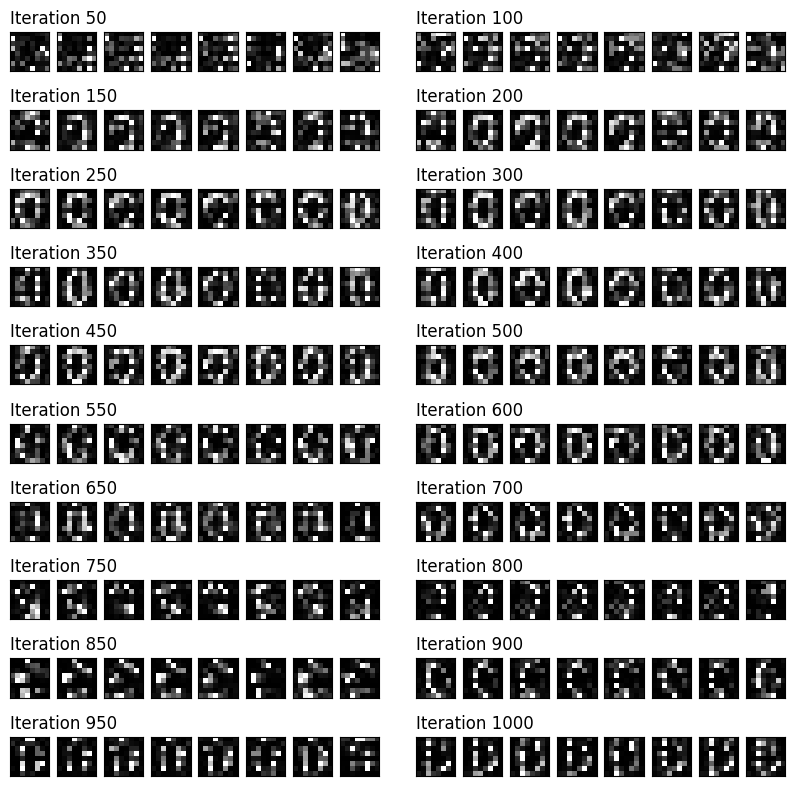

In [12]:
fig = plt.figure(figsize=(10, 10))
outer = gridspec.GridSpec(10, 2, wspace=0.1)

for i, images in enumerate(results):
    inner = gridspec.GridSpecFromSubplotSpec(1, images.size(0),
                    subplot_spec=outer[i])

    images = torch.squeeze(images, dim=1)
    for j, im in enumerate(images):

        ax = plt.Subplot(fig, inner[j])
        ax.imshow(im.numpy(), cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        if j==0:
            ax.set_title(f'Iteration {50+i*50}', loc='left')
        fig.add_subplot(ax)

plt.show()

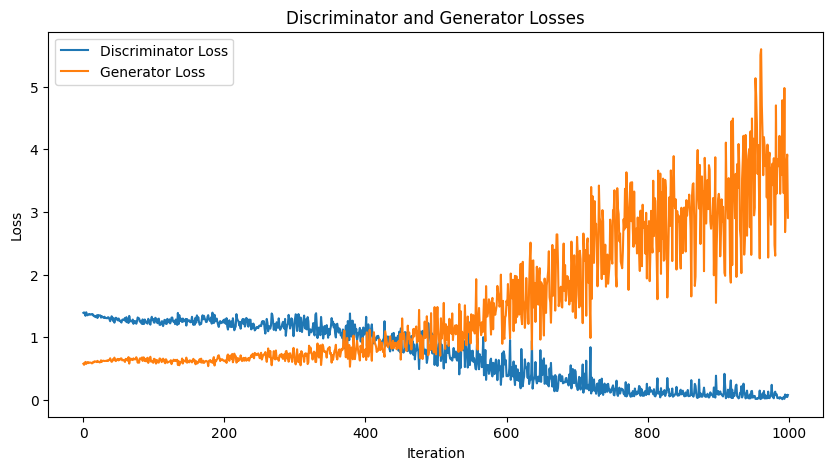

In [14]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(len(error_disc)), [val.cpu().detach().numpy() for val in error_disc], label='Discriminator Loss')
plt.plot(range(len(error_gen)), [val.cpu().detach().numpy() for val in error_gen], label='Generator Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Discriminator and Generator Losses')
plt.legend()
plt.show()